In [1]:
'''
Zé Fonseca

6/02/16

Test what happens when we fit y=mx+b and de have errors in y and x and when we let x be fitted as well
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
import emcee
%matplotlib inline
import time
import matplotlib.gridspec as gridspec



In [2]:
#functions
#cosmological functions
#general functions

def func(x,m=2,b=1):
    return m*x+b

#class for fake data. Only reason to use class is because this is a copy of another iPython Notebook

class fkd:
    def __init__(self,name,N=5,m=2,b=1,sig_y=0.01,sig_x=0.04):
        #parameters used
        self.N=N
        x=np.random.rand(N)
        x.sort()
        self.x=x
        self.y_t=m*self.x+b
        self.y=self.y_t+np.random.randn(N)*sig_y
        self.x2=x+np.random.randn(N)*sig_x
        self.sig_y=sig_y
        self.sig_x=sig_x
        self.dataset=name


In [3]:
#initiate data and simulate it
N=10
fd=fkd('str_x10',N)

# save data and plot it

def save_sim_data(data):
    np.savetxt('data_'+data.dataset+'_zf.txt',np.c_[data.x,data.x2,data.y],fmt='%2.3f',header="x  x2  y")

save_sim_data(fd)

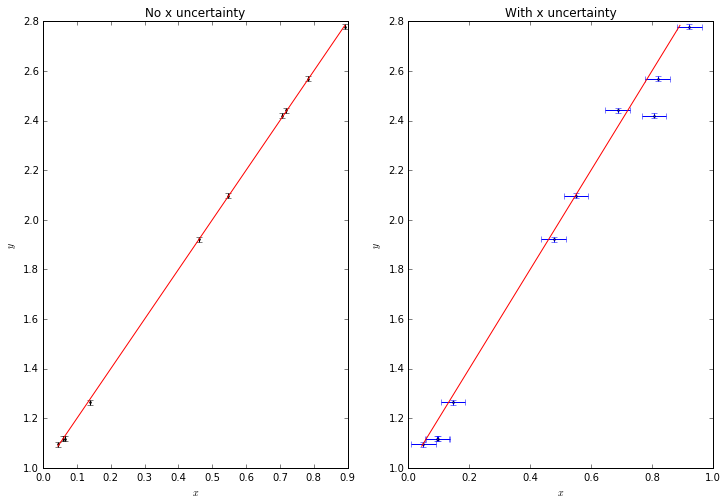

In [4]:
f, axarr = plt.subplots(1,2,figsize=(12,8))
    
axarr[0].errorbar(fd.x,fd.y,yerr=[0.01*np.ones(fd.N),0.01*np.ones(fd.N)],fmt='ko',ms=2)
axarr[0].plot(fd.x,fd.y_t,'r')
axarr[0].set_xlabel(r'$x$')
axarr[0].set_ylabel(r'$y$')
axarr[0].set_title('No x uncertainty')
    
axarr[1].errorbar(fd.x2,fd.y,xerr=[0.04*np.ones(fd.N),0.04*np.ones(fd.N)],yerr=[0.01*np.ones(fd.N),0.01*np.ones(fd.N)],fmt='bo',ms=2)
axarr[1].plot(fd.x,fd.y_t,'r')
axarr[1].set_xlabel(r'$x$')
axarr[1].set_ylabel(r'$y$')
axarr[1].set_title('With x uncertainty')

plt.savefig(fd.dataset+'_zf.pdf')
plt.show()

In [5]:
#MCMC priors

def l_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [[0, 4], [-5, 5]]
    for i in range(len(bounds)):
        if p[i]< bounds[i][0] or p[i] > bounds[i][1]:
            return False
    return True

def x_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [-1,2]
    for i in range(len(bounds)):
        if p[i]< bounds[0] or p[i] > bounds[1]:
            return False
    return True
    
def chi2_p(o,t,sigma2):
    return (o-t)**2/sigma2


In [6]:
def log_like_fix_x1(p,data):
    """
    Edited from Michelle Lochner
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    chi2 = np.sum(chi2_p(data.y,y_t,data.sig_y**2))   
    return -0.5*chi2

def log_like_fix_x2(p,data):
    """
    Edited from Michelle Lochner
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x2,m,b)
    chi2 = np.sum(chi2_p(data.y,y_t,data.sig_y**2))   
    return -0.5*chi2

def log_like_varsig(p,data):
    """
    Edited from Michelle Lochner
    Error varies at every step
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y,y_t,sigma2)+np.log(sigma2))*0.5

def log_like_strline(p,data):
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    chi2 = np.sum(chi2_p(data.y_t,y_t,data.sig_y**2))   
    return -0.5*chi2

def log_like_str_varsig_fid(p,data):
    if not l_prior(p):
        return -np.inf
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y_t,y_t,sigma2)+np.log(sigma2))*0.5

def log_like_str_varsig_xsct(p,data):
    if not l_prior(p):
        return -np.inf
    m,b = p[:2]    
    y_t = func(data.x2,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y_t,y_t,sigma2)+np.log(sigma2))*0.5

def log_like_str_varsig_nonorm(p,data):
    if not l_prior(p):
        return -np.inf
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y_t,y_t,sigma2))*0.5

def log_like_arabnight(p,data):
    m,b = p[:2]
    X=p[2:]
    
    if not l_prior(p[:3]) or not  x_prior(X):
        return -np.inf  
    
    y_t = func(X,m,b)
    
    chi2_y = np.sum(chi2_p(data.y,y_t,data.sig_y**2)) 
    chi2_x = np.sum(chi2_p(data.x2,X,data.sig_x**2)) 
    
    return -(chi2_y+chi2_x)*0.5

def log_like_arabnight_xfid(p,data):
    m,b = p[:2]
    X=p[2:]
    
    if not l_prior(p[:3]) or not  x_prior(X):
        return -np.inf  
    
    y_t = func(X,m,b)
    
    chi2_y = np.sum(chi2_p(data.y,y_t,data.sig_y**2)) 
    chi2_x = np.sum(chi2_p(data.x,X,data.sig_x**2)) 
    
    return -(chi2_y+chi2_x)*0.5

In [7]:
def run_chain(lnprob,data,start_point=[1.1,0.9], proposal_spread=[0.05, 0.05],
             nwalkers=500, ndim=2):
    """Function to run emcee on a dataset (suppied in args)"""
    t1 = time.time()
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))*np.array(proposal_spread) + np.array(start_point)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data])
    pos, prob, state = sampler.run_mcmc(p0,100)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos,5000)
    
    print('Dataset', data.dataset)

    print('Time taken', time.time() - t1)
    print('Average acceptance ratio', sampler.acceptance_fraction.mean())


    return sampler.flatchain

In [8]:
chain1_ab=run_chain(log_like_arabnight,fd,start_point=[1.1,0.9]+[0.5]*N,\
          proposal_spread=[0.05]*2+[0.1]*N,ndim=2+N)
chain1_sctx=run_chain(log_like_fix_x2,fd)
chain1_fid=run_chain(log_like_fix_x1,fd)
chain1_abfid=run_chain(log_like_arabnight_xfid,fd,start_point=[1.1,0.9]+[0.5]*N,\
          proposal_spread=[0.05]*2+[0.1]*N,ndim=2+N)
chain1_vsig_sctx=run_chain(log_like_str_varsig_xsct,fd)
chain1_vsig_fid=run_chain(log_like_str_varsig_fid,fd)

Dataset str_x10
Time taken 71.97509908676147
Average acceptance ratio 0.3817784
Dataset str_x10
Time taken 44.4179310798645
Average acceptance ratio 0.7157864
Dataset str_x10
Time taken 46.82004904747009
Average acceptance ratio 0.715446
Dataset str_x10
Time taken 83.73694801330566
Average acceptance ratio 0.3811092
Dataset str_x10
Time taken 47.06487703323364
Average acceptance ratio 0.7149272
Dataset str_x10
Time taken 41.48791193962097
Average acceptance ratio 0.7151516


In [9]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95


burn_tail=100
thining=1
nb=25

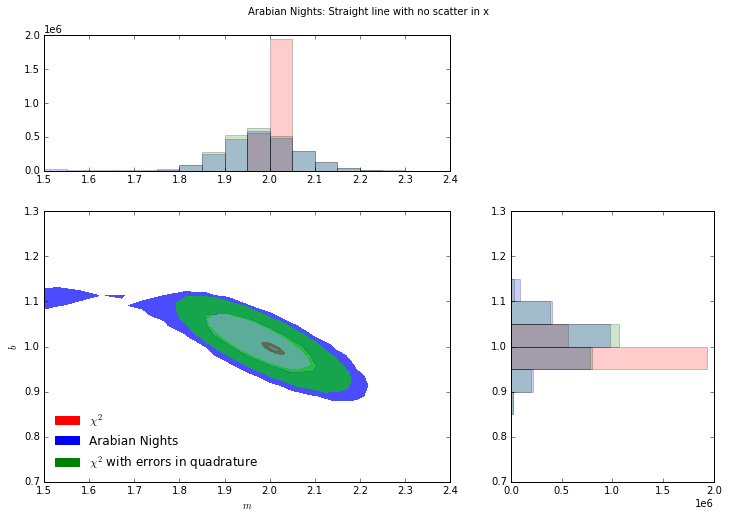

In [10]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.05+1,3) for x in range(0,100)]
bins_b=[round(x*0.05+0,3) for x in range(0,100)]

m1=chain1_fid[:,0]
b1=chain1_fid[:,1]
m2=chain1_abfid[:,0]
b2=chain1_abfid[:,1]
m3=chain1_vsig_fid[:,0]
b3=chain1_vsig_fid[:,1]

Hist_mcmc1, medges1,bedges1 = np.histogram2d(m1,b1,bins=(nb, nb))
m_c1=np.array([(medges1[i]+medges1[i+1])/2 for i in range(len(medges1)-1)])
b_c1=np.array([(bedges1[i]+bedges1[i+1])/2 for i in range(len(bedges1)-1)])
Neff1=len(m1)
Nmax1,N681,N951=confidence_levels(Hist_mcmc1,Neff1)

Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
Neff2=len(m2)
Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)

Hist_mcmc3, medges3,bedges3 = np.histogram2d(m3,b3,bins=(nb, nb))
m_c3=np.array([(medges3[i]+medges3[i+1])/2 for i in range(len(medges3)-1)])
b_c3=np.array([(bedges3[i]+bedges3[i+1])/2 for i in range(len(bedges3)-1)])
Neff3=len(m3)
Nmax3,N683,N953=confidence_levels(Hist_mcmc3,Neff3)

f.text(0.5, 0.95, 'Arabian Nights: Straight line with no scatter in x',horizontalalignment='center',verticalalignment='top')
    
m_min=1.5
m_max=2.4
    
b_min=0.7
b_max=1.3


ax1.hist(m1,color='r',bins=bins_m,alpha=0.2)
ax1.hist(m2,color='b',bins=bins_m,alpha=0.2)
ax1.hist(m3,color='g',bins=bins_m,alpha=0.2)
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax1.set_yticks([1e5,2e5,3e5,4e5])
#ax1.set_yticklabels([r'$10^5$',r'$2 10^5$',r'$3 10^5$',r'$4 10^5$'])

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)
colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap2 = mpl.colors.ListedColormap(colors2)
colors3 = [(0.0, .8, 0.0, 0.7),(0.0, 0.8, 0.0, 0.4)] 
cmap3 = mpl.colors.ListedColormap(colors3)
    
ax3.contourf(m_c1,b_c1, Hist_mcmc1.T,levels=[N951,N681,Nmax1],cmap=cmap1)
ax3.contourf(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
ax3.contourf(m_c3,b_c3, Hist_mcmc3.T,levels=[N953,N683,Nmax3],cmap=cmap3)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b1,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
ax4.hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.hist(b3,bins=bins_b,color='g',alpha=0.2,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
#ax4.set_xticks([1e5,2e5,3e5,4e5,5e5])
#ax4.set_xticklabels([r'$10^5$',r'$2 10^5$',r'$3 10^5$',r'$4\ 10^5$',r'$5\ 10^5$'])
#ticks = ax4.get_xticks()*10**5
#ax4.set_xticklabels(ticks)
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label=r'$\chi^2$')
blue_patch = mpatches.Patch(color='blue', label='Arabian Nights')
green_patch = mpatches.Patch(color='green', label=r'$\chi^2$ with errors in quadrature')
ax3.legend(handles=[red_patch,blue_patch,green_patch],fontsize=12, loc = 'lower left',frameon=False)
plt.savefig('arabnight_str_noxsct_'+str(N)+'_zf.png')
    
plt.show()

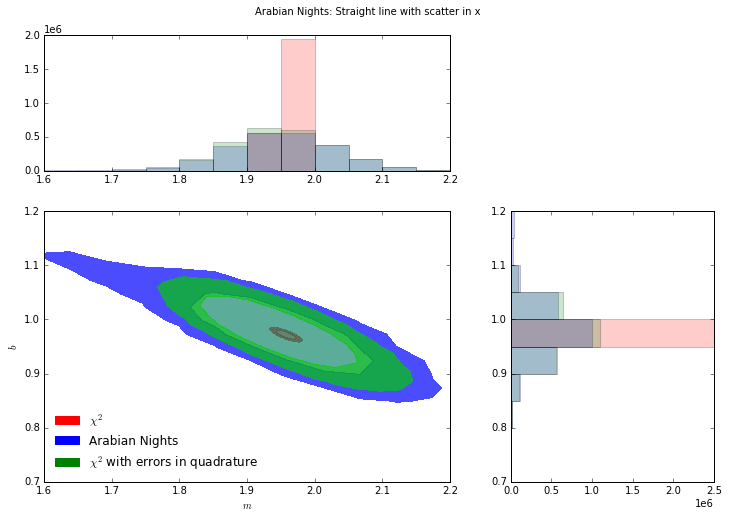

In [13]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.05+1,3) for x in range(0,100)]
bins_b=[round(x*0.05+0,3) for x in range(0,100)]

m1=chain1_sctx[:,0]
b1=chain1_sctx[:,1]
m2=chain1_ab[:,0]
b2=chain1_ab[:,1]
m3=chain1_vsig_sctx[:,0]
b3=chain1_vsig_sctx[:,1]

Hist_mcmc1, medges1,bedges1 = np.histogram2d(m1,b1,bins=(nb, nb))
m_c1=np.array([(medges1[i]+medges1[i+1])/2 for i in range(len(medges1)-1)])
b_c1=np.array([(bedges1[i]+bedges1[i+1])/2 for i in range(len(bedges1)-1)])
Neff1=len(m1)
Nmax1,N681,N951=confidence_levels(Hist_mcmc1,Neff1)

Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
Neff2=len(m2)
Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)

Hist_mcmc3, medges3,bedges3 = np.histogram2d(m3,b3,bins=(nb, nb))
m_c3=np.array([(medges3[i]+medges3[i+1])/2 for i in range(len(medges3)-1)])
b_c3=np.array([(bedges3[i]+bedges3[i+1])/2 for i in range(len(bedges3)-1)])
Neff3=len(m3)
Nmax3,N683,N953=confidence_levels(Hist_mcmc3,Neff3)

f.text(0.5, 0.95, 'Arabian Nights: Straight line with scatter in x',horizontalalignment='center',verticalalignment='top')
    
m_min=1.6
m_max=2.2
    
b_min=0.7
b_max=1.2


ax1.hist(m1,color='r',bins=bins_m,alpha=0.2)
ax1.hist(m2,color='b',bins=bins_m,alpha=0.2)
ax1.hist(m3,color='g',bins=bins_m,alpha=0.2)
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax1.set_yticks([1e5,2e5,3e5,4e5])
#ax1.set_yticklabels([r'$10^5$',r'$2 10^5$',r'$3 10^5$',r'$4 10^5$'])

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)
colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap2 = mpl.colors.ListedColormap(colors2)
colors3 = [(0.0, .8, 0.0, 0.7),(0.0, 0.8, 0.0, 0.4)] 
cmap3 = mpl.colors.ListedColormap(colors3)
    
ax3.contourf(m_c1,b_c1, Hist_mcmc1.T,levels=[N951,N681,Nmax1],cmap=cmap1)
ax3.contourf(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
ax3.contourf(m_c3,b_c3, Hist_mcmc3.T,levels=[N953,N683,Nmax3],cmap=cmap3)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b1,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
ax4.hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.hist(b3,bins=bins_b,color='g',alpha=0.2,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
#ax4.set_xticks([1e5,2e5,3e5,4e5,5e5])
#ax4.set_xticklabels([r'$10^5$',r'$2 10^5$',r'$3 10^5$',r'$4\ 10^5$',r'$5\ 10^5$'])
#ticks = ax4.get_xticks()*10**5
#ax4.set_xticklabels(ticks)
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label=r'$\chi^2$')
blue_patch = mpatches.Patch(color='blue', label='Arabian Nights')
green_patch = mpatches.Patch(color='green', label=r'$\chi^2$ with errors in quadrature')
ax3.legend(handles=[red_patch,blue_patch,green_patch],fontsize=12, loc = 'lower left',frameon=False)

plt.savefig('arabnight_str_xsct_'+str(N)+'_zf.png')

    
plt.show()

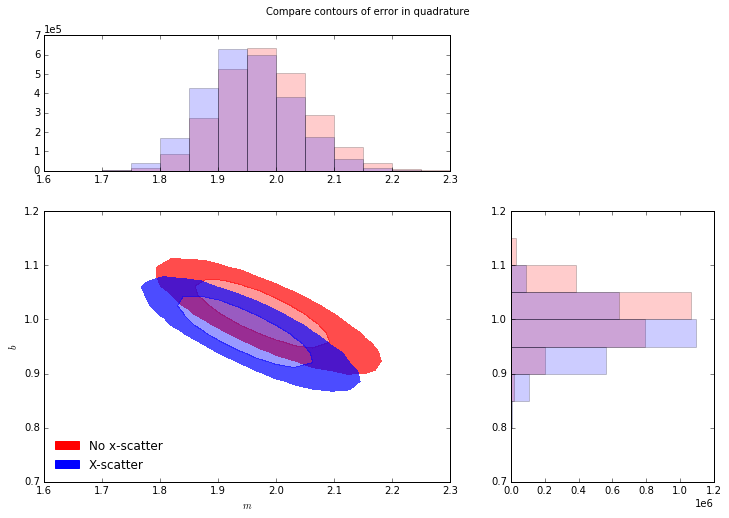

In [15]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.05+1,3) for x in range(0,100)]
bins_b=[round(x*0.05+0,3) for x in range(0,100)]

m1=chain1_vsig_fid[:,0]
b1=chain1_vsig_fid[:,1]
m2=chain1_vsig_sctx[:,0]
b2=chain1_vsig_sctx[:,1]

Hist_mcmc1, medges1,bedges1 = np.histogram2d(m1,b1,bins=(nb, nb))
m_c1=np.array([(medges1[i]+medges1[i+1])/2 for i in range(len(medges1)-1)])
b_c1=np.array([(bedges1[i]+bedges1[i+1])/2 for i in range(len(bedges1)-1)])
Neff1=len(m1)
Nmax1,N681,N951=confidence_levels(Hist_mcmc1,Neff1)

Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
Neff2=len(m2)
Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)

f.text(0.5, 0.95, 'Compare contours of error in quadrature',horizontalalignment='center',verticalalignment='top')
    
m_min=1.6
m_max=2.3
    
b_min=0.7
b_max=1.2


ax1.hist(m1,color='r',bins=bins_m,alpha=0.2)
ax1.hist(m2,color='b',bins=bins_m,alpha=0.2)
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax1.set_yticks([1e5,2e5,3e5,4e5])
#ax1.set_yticklabels([r'$10^5$',r'$2 10^5$',r'$3 10^5$',r'$4 10^5$'])

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)
colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap2 = mpl.colors.ListedColormap(colors2)
    
ax3.contourf(m_c1,b_c1, Hist_mcmc1.T,levels=[N951,N681,Nmax1],cmap=cmap1)
ax3.contourf(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b1,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
ax4.hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='No x-scatter')
blue_patch = mpatches.Patch(color='blue', label='X-scatter')
ax3.legend(handles=[red_patch,blue_patch],fontsize=12, loc = 'lower left',frameon=False)
#plt.savefig('bias_mdenominator_str_zf.png')
    
plt.show()